## Big data analytics: Big Data Bowl 
Authored by Jason Maloney and Jesse Pezzillo

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
# This dataset can be downloaded from https://www.kaggle.com/c/nfl-big-data-bowl-2020/data after an agreement is digitally signed through kaggle. 
data = pd.read_csv('train.csv')
#lower all columns
data.columns = map(str.lower, data.columns)

#### View the data and types

In [3]:
print(data.dtypes)

gameid                      int64
playid                      int64
team                       object
x                         float64
y                         float64
s                         float64
a                         float64
dis                       float64
orientation               float64
dir                       float64
nflid                       int64
displayname                object
jerseynumber                int64
season                      int64
yardline                    int64
quarter                     int64
gameclock                  object
possessionteam             object
down                        int64
distance                    int64
fieldposition              object
homescorebeforeplay         int64
visitorscorebeforeplay      int64
nflidrusher                 int64
offenseformation           object
offensepersonnel           object
defendersinthebox         float64
defensepersonnel           object
playdirection              object
timehandoff   

In [4]:
data.head()

,gameid,playid,team,x,y,s,a,dis,orientation,dir,...,week,stadium,location,stadiumtype,turf,gameweather,temperature,humidity,windspeed,winddirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW


#### Player height

In [5]:
# create function to convert playerHeight to inches
def heightToInches(x):
    try:
        x,x1 = x.split('-')
        x = int(x)
        x1 = int(x1)
        x = (12*x) + x1
        return(x)
    except:
        return int(x*12)

In [6]:
# run function over column
data["playerheight"] = data["playerheight"].apply(heightToInches)

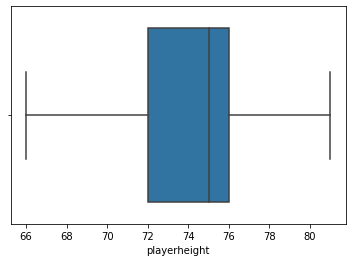

In [7]:
sns.boxplot(data["playerheight"])
plt.show()

#### Player age

In [8]:
# convert TimeHandoff to dates and times
data['timehandoff'] = pd.to_datetime(data['timehandoff'])
data['timesnap'] = pd.to_datetime(data['timesnap'])
data['playerbirthdate'] = pd.to_datetime(data["playerbirthdate"])
# confirm dtype
print('handoff time:',data["timehandoff"].dtype)
print('snap time:',data["timesnap"].dtype)
print('playerbirthdate',data["playerbirthdate"].dtype)

handoff time: datetime64[ns, UTC]
snap time: datetime64[ns, UTC]
playerbirthdate datetime64[ns]


In [9]:
# generate age of each player
def birthDayCalc(df):
    birthDay = df[0].year
    timeHandoff = df[1].year
    age = (timeHandoff - birthDay) #/ 365.25
    return age
data["age"] = data[["playerbirthdate","timehandoff"]].apply(birthDayCalc, axis=1)

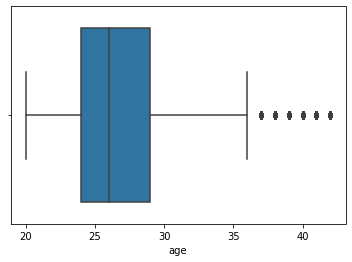

Player anomolies/Old dudes


array(['Tom Brady', 'Josh McCown', 'Benjamin Watson', 'James Harrison',
       'Carson Palmer', 'Julius Peppers', 'Drew Brees', 'Terence Newman',
       'Antonio Gates', 'Dwight Freeney', 'Mike Adams', 'Philip Rivers',
       'Karlos Dansby', 'Eli Manning', 'Andrew Whitworth', 'Matt Schaub',
       'Cameron Wake', 'Ryan Fitzpatrick', 'Jason Peters',
       'Terrell Suggs', 'Jason Witten', 'Ben Roethlisberger'],
      dtype=object)

In [33]:
sns.boxplot(data["age"])
plt.show()
print("Player anomolies/Old dudes:")
data['displayname'][data["age"] > 36].unique()

In [11]:
# convert windspeed
def windConvert(x):
    try:
        x = re.match('[0-9]+',x)
        x = x.groups()
        for i in x:
            y += i
            return(y)
    except:
        return(x)
data["windspeed"] = data["windspeed"].apply(windConvert)

In [12]:
data["windspeed"].unique()

array([ 8.,  6., 10.,  9., 11., nan,  7.,  5.,  2., 12.,  1.,  3.,  4.,
       13., 14.,  0., 15., 17., 18., 16., 24., 23., 19.])

In [20]:
# oreintation fix
# Refrenced this notebook to help understand how to modify https://www.kaggle.com/ben519/understanding-x-y-dir-and-orientation


array([2017, 2018, 2019], dtype=int64)

In [11]:
# create a rusher dummy variable
data['rusher'] = 0
data['rusher'][data['nflid'] == data['nflidrusher']] = 1

### Feature generation

In [12]:
# get Rusher X and Y
pos_df = pd.DataFrame(zip(data['x'][data['rusher'] == 1], data['y'][data['rusher'] == 1]), columns = ['x', 'y'])
pos_df.head()

,x,y
0,78.75,30.53
1,71.07,27.16
2,48.66,19.11
3,15.53,25.36
4,29.99,27.12


In [13]:
# need to get each value repeated 22 times, for each player in each play
posdf = pd.DataFrame(zip(pos_df['x'].repeat(22), pos_df['y'].repeat(22)), index = range(len(data)), columns = ['rushx', 'rushy'])
# put the rushX and rushY in the main df
data['rushx'] = posdf['rushx']
data['rushy'] = posdf['rushy']

In [14]:
# euclidean dist = sqrt((x1 - x2)^2 + (y1 - y2)^2) - straight line distance
data['disttorush'] = np.sqrt((data['x'] - data['rushx'])**2 + (data['y'] - data['rushy'])**2)
data.head()

,gameid,playid,team,x,y,s,a,dis,orientation,dir,...,gameweather,temperature,humidity,windspeed,winddirection,age,rusher,rushx,rushy,disttorush
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,...,Clear and warm,63.0,77.0,8.0,SW,29,0,78.75,30.53,6.480872
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,...,Clear and warm,63.0,77.0,8.0,SW,28,0,78.75,30.53,4.593310
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,...,Clear and warm,63.0,77.0,8.0,SW,28,0,78.75,30.53,5.448982
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,...,Clear and warm,63.0,77.0,8.0,SW,35,0,78.75,30.53,7.820038
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,...,Clear and warm,63.0,77.0,8.0,SW,30,0,78.75,30.53,10.622476


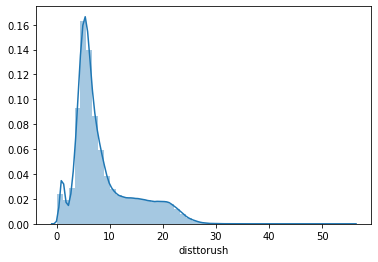

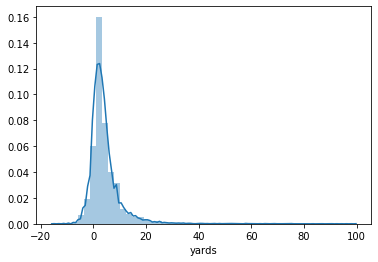

In [15]:
sns.distplot(data['disttorush'][data['rusher'] == 0])
plt.show()

sns.distplot(data['yards'])
plt.show()

In [16]:
# most general form for offense
# not quite sure how to go about this, if we even do...maybe just leave it categorical
# QB - OL - RB - TE - WR - defensive (oDB, oDL, oLB)

# split up each entry
# create a new list where each entry is QB [0] - OL[1] - RB [2] - TE [3] - WR [4]
# TRY TO DO IT WITHOUT FOR LOOPS

In [17]:
# find the count of each position
# convert to int
# store
#ol = []
#rb = []
#te = []
#wr = []
#for pers in oi:
    # this finds the numbers - all personnel in the same order OL RB TE WR 
    # stores the number as a string
#    val = re.findall('\d', pers)
    # convert to an int and store
#    ol.append(int(val[0]))
#    rb.append(int(val[1]))
#    te.append(int(val[2]))
#    wr.append(int(val[3]))

# in the future - values of 0 OL = 11 - (sum(wr,rb,te)+1(qb))

In [18]:
# split at the comma - OL RB TE WR
#oi = []
#for i in range(len(subset)):
#    op = subset['OffensePersonnel'][i]
#    if 'OL' not in op:
#        newofper = '0 OL, ' + op
#    else:
#        newofper = subset['OffensePersonnel'][i]
#    oi.append(newofper)
#oi.head()


In [19]:
# do the same for defense
# what are the positions?
#set(subset['DefensePersonnel'])
# no missing values, so just need to get the digits
# order is DL LB DB
#dl = []
#lb = []
#db = []
#for pers in subset['DefensePersonnel']:
#   val = re.findall('\d', pers)
#    # dl = val[0], lb = val[1], db = val[2]
#    dl.append(int(val[0]))
#    lb.append(int(val[1]))
#    db.append(int(val[2]))